In [70]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report 
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
df_train = pd.read_csv('../data/train.csv')
df_valid = pd.read_csv('../data/val.csv')

In [3]:
df_train_encoded = df_train.copy()
categorical_features = ['Gender', 'H_Cal_Consump',
 'Alcohol_Consump', 'Smoking',
 'Food_Between_Meals', 'Fam_Hist',
 'H_Cal_Burn', 'Phys_Act', 'Transport']
for feature in categorical_features:
 le = LabelEncoder()
 df_train_encoded[feature] = le.fit_transform(df_train_encoded[feature])


df_train_encoded['Body_Level'] = df_train_encoded['Body_Level'].map({'Body Level 1':1,
                                                                     'Body Level 2':2,
                                                                     'Body Level 3':3,
                                                                     'Body Level 4':4})

df_valid_encoded = df_valid.copy()
for feature in categorical_features:
    le = LabelEncoder()
    df_valid_encoded[feature] = le.fit_transform(df_valid_encoded[feature])

df_valid_encoded['Body_Level'] = df_valid_encoded['Body_Level'].map({'Body Level 1':1,
                                                                     'Body Level 2':2,
                                                                     'Body Level 3':3,
                                                                     'Body Level 4':4})

In [15]:
# Create and fit a GMM for each class
gmms = {}
for label in np.unique(df_train_encoded['Body_Level']):
    gmms[label] = GaussianMixture(n_components=1)
    gmms[label].fit(df_train_encoded[df_train_encoded['Body_Level'] == label].drop(['Body_Level'], axis=1))

In [16]:
# Compute the posterior probabilities for a new data point

posterior_probs = np.zeros((len(df_valid_encoded), len(gmms)))
for i, (label, gmm) in enumerate(gmms.items()):
    posterior_probs[:, i] = gmm.score_samples(df_valid_encoded.drop('Body_Level', axis=1))

predicted_labels = np.argmax(posterior_probs, axis=1) + 1
print(classification_report(df_valid_encoded['Body_Level'], predicted_labels))


              precision    recall  f1-score   support

           1       0.97      0.94      0.96        34
           2       0.76      0.88      0.81        42
           3       0.91      0.51      0.66        80
           4       0.81      0.98      0.89       140

    accuracy                           0.83       296
   macro avg       0.86      0.83      0.83       296
weighted avg       0.85      0.83      0.82       296



## Bias Variance Tradeoff

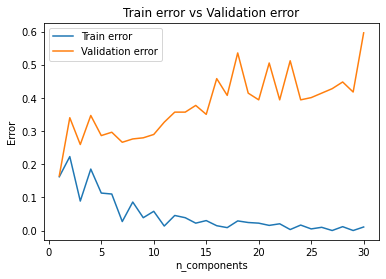

In [18]:
# Get train & validation errors for n_components from 1 to 31
train_errors = []
valid_errors = []
for n_components in range(1, 31):
    # Create and fit a GMM for each class
    gmms = {}
    for label in np.unique(df_train_encoded['Body_Level']):
        gmms[label] = GaussianMixture(n_components=n_components)
        gmms[label].fit(df_train_encoded[df_train_encoded['Body_Level'] == label].drop(['Body_Level'], axis=1))

    # Compute the posterior probabilities for a new data point
    posterior_probs = np.zeros((len(df_train_encoded), len(gmms)))
    for i, (label, gmm) in enumerate(gmms.items()):
        posterior_probs[:, i] = gmm.score_samples(df_train_encoded.drop('Body_Level', axis=1))

    predicted_labels = np.argmax(posterior_probs, axis=1) + 1
    train_errors.append(np.mean(predicted_labels != df_train_encoded['Body_Level']))

    posterior_probs = np.zeros((len(df_valid_encoded), len(gmms)))
    for i, (label, gmm) in enumerate(gmms.items()):
        posterior_probs[:, i] = gmm.score_samples(df_valid_encoded.drop('Body_Level', axis=1))

    predicted_labels = np.argmax(posterior_probs, axis=1) + 1
    valid_errors.append(np.mean(predicted_labels != df_valid_encoded['Body_Level']))

# Plot the train & validation errors
import matplotlib.pyplot as plt
plt.plot(range(1, 31), train_errors, label='Train error')
plt.plot(range(1, 31), valid_errors, label='Validation error')
plt.title('Train error vs Validation error')
plt.xlabel('n_components')
plt.ylabel('Error')
plt.legend()
plt.show()

## Observations

This bias variance tradeoff plot looks more like the ones we took in our lectures, as the n_components increases, the model complexity increases, which leads to less training errors but more validation error (less bias but more variance). and the generalization performance of the model decreases because of that.

## Class Imbalance

In [20]:
# Try out all the other Datasets in class_imbalance folder
x_train_undersampled = pd.read_csv('../data/class_Imbalance/X_under_sampled_no_relationship.csv')
y_train_undersampled = pd.read_csv('../data/class_Imbalance/y_under_sampled_no_relationship.csv')

x_train_oversampled = pd.read_csv('../data/class_Imbalance/X_over_sampled_no_relationship.csv')
y_train_oversampled = pd.read_csv('../data/class_Imbalance/y_over_sampled_no_relationship.csv')

x_train_smotenc = pd.read_csv('../data/class_Imbalance/X_SMOTENC_no_relationship.csv')
y_train_smotenc = pd.read_csv('../data/class_Imbalance/y_SMOTENC_no_relationship.csv')

y_train_smotenc = y_train_smotenc.rename(columns={'Body_Level_Num': 'Body_Level'})
y_train_smotenc['Body_Level'] = y_train_smotenc['Body_Level'].map({1: 'Body Level 1', 2: 'Body Level 2', 3: 'Body Level 3', 4: 'Body Level 4'})


x_train_smote_with_importance = pd.read_csv('../data/class_Imbalance/X_SMOTE_with_importance.csv')
y_train_smote_with_importance = pd.read_csv('../data/class_Imbalance/y_SMOTE_with_importance.csv')

y_train_smote_with_importance = y_train_smote_with_importance.rename(columns={'Body_Level_Num': 'Body_Level'})

y_train_smote_with_importance['Body_Level'] = y_train_smote_with_importance['Body_Level'].map({1: 'Body Level 1', 2: 'Body Level 2', 3: 'Body Level 3', 4: 'Body Level 4'})


In [51]:
# Print the number of samples in each class for each dataset
print('Number of samples in each class for x_train_undersampled')
print(y_train_undersampled['Body_Level'].value_counts())
print('Number of samples in each class for x_train_oversampled')
print(y_train_oversampled['Body_Level'].value_counts())
print('Number of samples in each class for x_train_smotenc')
print(y_train_smotenc['Body_Level'].value_counts())
print('Number of samples in each class for x_train_smote_with_importance')
print(y_train_smote_with_importance['Body_Level'].value_counts())

Number of samples in each class for x_train_undersampled
Body Level 1    135
Body Level 2    135
Body Level 3    135
Body Level 4    135
Name: Body_Level, dtype: int64
Number of samples in each class for x_train_oversampled
Body Level 3    472
Body Level 2    472
Body Level 4    472
Body Level 1    472
Name: Body_Level, dtype: int64
Number of samples in each class for x_train_smotenc
Body Level 3    472
Body Level 2    472
Body Level 4    472
Body Level 1    472
Name: Body_Level, dtype: int64
Number of samples in each class for x_train_smote_with_importance
Body Level 4    177564
Body Level 3    106839
Body Level 1     53419
Body Level 2     50786
Name: Body_Level, dtype: int64


In [23]:
# Encode categorical features
x_train_undersampled_encoded = x_train_undersampled.copy()
x_train_oversampled_encoded = x_train_oversampled.copy()
x_train_smotenc_encoded = x_train_smotenc.copy()
x_train_smote_with_importance_encoded = x_train_smote_with_importance.copy()

for feature in categorical_features:
    le = LabelEncoder()
    x_train_undersampled_encoded[feature] = le.fit_transform(x_train_undersampled_encoded[feature])
    x_train_oversampled_encoded[feature] = le.fit_transform(x_train_oversampled_encoded[feature])
    x_train_smotenc_encoded[feature] = le.fit_transform(x_train_smotenc_encoded[feature])
    x_train_smote_with_importance_encoded[feature] = le.fit_transform(x_train_smote_with_importance_encoded[feature])

In [47]:
# Undersampled Data
gmms = {}
for label in np.unique(y_train_undersampled['Body_Level']):
    gmms[label] = GaussianMixture(n_components=1)
    gmms[label].fit(x_train_undersampled_encoded[y_train_undersampled['Body_Level'] == label])

# Compute the posterior probabilities for a new data point
posterior_probs = np.zeros((len(df_valid_encoded), len(gmms)))
for i, (label, gmm) in enumerate(gmms.items()):
    posterior_probs[:, i] = gmm.score_samples(df_valid_encoded.drop('Body_Level', axis=1))

predicted_labels = np.argmax(posterior_probs, axis=1) + 1

print(classification_report(df_valid_encoded['Body_Level'], predicted_labels))

              precision    recall  f1-score   support

           1       0.97      0.94      0.96        34
           2       0.76      0.90      0.83        42
           3       0.86      0.70      0.77        80
           4       0.89      0.94      0.92       140

    accuracy                           0.87       296
   macro avg       0.87      0.87      0.87       296
weighted avg       0.87      0.87      0.87       296



In [48]:
# Oversampled Data
gmms = {}
for label in np.unique(y_train_oversampled['Body_Level']):
    gmms[label] = GaussianMixture(n_components=1)
    gmms[label].fit(x_train_oversampled_encoded[y_train_oversampled['Body_Level'] == label])

# Compute the posterior probabilities for a new data point
posterior_probs = np.zeros((len(df_valid_encoded), len(gmms)))
for i, (label, gmm) in enumerate(gmms.items()):
    posterior_probs[:, i] = gmm.score_samples(df_valid_encoded.drop('Body_Level', axis=1))

predicted_labels = np.argmax(posterior_probs, axis=1) + 1

print(classification_report(df_valid_encoded['Body_Level'], predicted_labels))

              precision    recall  f1-score   support

           1       0.97      0.94      0.96        34
           2       0.77      0.88      0.82        42
           3       0.91      0.53      0.67        80
           4       0.81      0.98      0.89       140

    accuracy                           0.84       296
   macro avg       0.87      0.83      0.83       296
weighted avg       0.85      0.84      0.83       296



In [49]:
# SMOTENC Data
gmms = {}
for label in np.unique(y_train_smotenc['Body_Level']):
    gmms[label] = GaussianMixture(n_components=1)
    gmms[label].fit(x_train_smotenc_encoded[y_train_smotenc['Body_Level'] == label])

# Compute the posterior probabilities for a new data point
posterior_probs = np.zeros((len(df_valid_encoded), len(gmms)))
for i, (label, gmm) in enumerate(gmms.items()):
    posterior_probs[:, i] = gmm.score_samples(df_valid_encoded.drop('Body_Level', axis=1))

predicted_labels = np.argmax(posterior_probs, axis=1) + 1

print(classification_report(df_valid_encoded['Body_Level'], predicted_labels))

              precision    recall  f1-score   support

           1       1.00      0.79      0.89        34
           2       0.73      0.86      0.79        42
           3       0.88      0.56      0.69        80
           4       0.81      0.98      0.89       140

    accuracy                           0.83       296
   macro avg       0.86      0.80      0.81       296
weighted avg       0.84      0.83      0.82       296



In [50]:
# SMOTE with importance Data
gmms = {}
for label in np.unique(y_train_smote_with_importance['Body_Level']):
    gmms[label] = GaussianMixture(n_components=1)
    gmms[label].fit(x_train_smote_with_importance_encoded[y_train_smote_with_importance['Body_Level'] == label])

# Compute the posterior probabilities for a new data point
posterior_probs = np.zeros((len(df_valid_encoded), len(gmms)))
for i, (label, gmm) in enumerate(gmms.items()):
    posterior_probs[:, i] = gmm.score_samples(df_valid_encoded.drop('Body_Level', axis=1))

predicted_labels = np.argmax(posterior_probs, axis=1) + 1

print(classification_report(df_valid_encoded['Body_Level'], predicted_labels))


              precision    recall  f1-score   support

           1       0.97      0.85      0.91        34
           2       0.79      0.79      0.79        42
           3       0.84      0.78      0.81        80
           4       0.91      0.97      0.94       140

    accuracy                           0.88       296
   macro avg       0.87      0.85      0.86       296
weighted avg       0.88      0.88      0.88       296



## Observations

It's clear that undersampling as well as smotenc with importance are the best. & the f1-score for each class reflects the number of data points for each class in the dataset. (In the Smote with importance, class 4 is the most numerous and it has the highest recall, but a little lower in precision).

## Regularization

100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


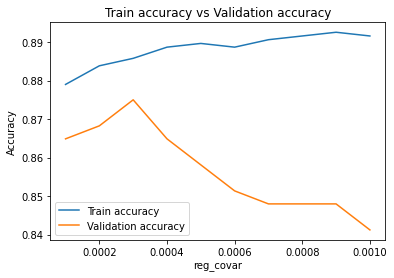

In [77]:
# Test the effect of regularization on the model
# Will use the original data for this

# Get the accuracies for different regularization values
train_accuracies = []
valid_accuracies = []

for reg in tqdm(np.linspace(0.1, 1, 10)):
    # Create and fit a GMM for each class
    gmms = {}
    for label in np.unique(df_train_encoded['Body_Level']):
        gmms[label] = GaussianMixture(n_components=1, reg_covar=reg * 1e-3)
        gmms[label].fit(df_train_encoded[df_train_encoded['Body_Level'] == label].drop('Body_Level', axis=1))

    # Compute the posterior probabilities for a new data point
    posterior_probs = np.zeros((len(df_train_encoded), len(gmms)))
    for i, (label, gmm) in enumerate(gmms.items()):
        posterior_probs[:, i] = gmm.score_samples(df_train_encoded.drop('Body_Level', axis=1))

    predicted_labels = np.argmax(posterior_probs, axis=1) + 1
    train_accuracies.append(np.mean(predicted_labels == df_train_encoded['Body_Level']))

    posterior_probs = np.zeros((len(df_valid_encoded), len(gmms)))
    for i, (label, gmm) in enumerate(gmms.items()):
        posterior_probs[:, i] = gmm.score_samples(df_valid_encoded.drop('Body_Level', axis=1))

    predicted_labels = np.argmax(posterior_probs, axis=1) + 1
    valid_accuracies.append(np.mean(predicted_labels == df_valid_encoded['Body_Level']))

# Plot the train & validation errors
plt.plot(np.linspace(0.1, 1, 10) * 1e-3, train_accuracies, label='Train accuracy')
plt.plot(np.linspace(0.1, 1, 10) * 1e-3, valid_accuracies, label='Validation accuracy')
plt.title('Train accuracy vs Validation accuracy')
plt.xlabel('reg_covar')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Observations

It's clear that regularization does have an effect on the accuracy of the model, to a certain extent, regularization can be beneficial, but after a certain point, it reduces the validation accuracy & leads to worse generalization.

I'm not sure how to interpret these results, as I understand, since both train & validation accuracies increase initially, this means that the model was initially a little overfitted but regularization helped. Then the model becomes underfit & this leads to worse validation accuracy. I'm not sure why the train accuracy increases though.